# Anderson Chain Model


The Hamiltonian is given by

$$
\mathcal{H} = \sum_{i = 1}^{L - 1} (|i \rangle \langle i+1| + |i+1 \rangle \langle i|) + \sum_{i = 1}^{L} \epsilon_i |i\rangle \langle i|
$$

where $|i \rangle$ denotes a state perfectly localized at site $i$. The disordered onsite potentials, $\{ \epsilon_i \}$, are randomly drawn from a gaussian distribution with zero mean and standard deviation $\frac{W}{\sqrt{3}}$.

Each eigenfunction $|E\rangle$ of this Hamiltonian is characterized by a center site $j_\circ$ and a localization length $\xi$, $~\langle i | E \rangle \propto \exp\left(−\frac{|i − j_\circ|}{\xi}\right)$. The disorder average of localization lengths at the band center attributes an average localization length $~\bar{\xi}~$ to a given disorder strength $W$.


Let we have a chain of $L$ sites. The Hamiltonian can be written in the matrix form as

$$
\mathcal{H} = \begin{pmatrix}
\epsilon_1 & 1 & 0 & \cdots & 0 & 0 & 0 \\
1 & \epsilon_2 & 1  & \cdots & 0 & 0 & 0 \\
0 & 1 & \epsilon_3  & \cdots & 0 & 0 & 0 \\
\vdots & \vdots  & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & \cdots & \epsilon_{L-2} & 1 & 0 \\
0 & 0 & 0 & \cdots & 1 & \epsilon_{L-1} & 1 \\
0 & 0 & 0 & \cdots & 0 & 1 & \epsilon_L
\end{pmatrix}_{L \times L}
$$


In [1]:
# again, this only works on startup!
from jax import jit, random, lax
import jax

jax.config.update("jax_enable_x64", True)

In [2]:
from functools import partial
import seaborn as sns
import matplotlib.colors as colors
import numpy as np
import jax.numpy as jnp

# import scipy as sp
import jax.scipy as jsp
import scipy.constants as const
import sympy as sym

import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "ieee", "grid"])

### Definition of the Hamiltonian


In [3]:
@partial(jit, static_argnames=("L"))
def anderson_hamiltonian(L: jnp.int64, J: jnp.float64, W: jnp.float64, seed: jnp.int64):
    """
    Generate a Anderson model Hamiltonian.

    Parameters
    ----------
    L : jnp.int64
        The number of sites.
    J : jnp.float64
        The hopping parameter.
    W : jnp.float64
        The disorder strength.
    seed : jnp.int64
        The seed for the random number generator.

    Returns
    -------
    H : jnp.ndarray
        The Hamiltonian.
    """
    μ = 0.0
    σ = W / jnp.sqrt(3)
    key = random.PRNGKey(seed)

    diag = μ + σ * random.normal(key, shape=(L,))

    H = jnp.diag(diag) + J * (
        jnp.diag(jnp.ones(L - 1), k=1) + jnp.diag(jnp.ones(L - 1), k=-1)
    )

    return H, diag

L = 10
J = 1.0
W = 2.0
key = 1701

H, diag = anderson_hamiltonian(L, J, W, key)

print(diag.mean(), diag.std())
sym.Matrix(H)


### Time evolution of the state


In [4]:
@partial(jax.jit, static_argnames=("n_steps"))
def time_evolution(
    H: jnp.ndarray, psi: jnp.ndarray, t: jnp.float64, n_steps: int = 100
):
    """
    Time-evolves a state under a given Hamiltonian.

    Parameters:
    H (jnp.ndarray): The Hamiltonian matrix.
    psi (jnp.ndarray): The initial state vector.
    t (float): The time to evolve the state to.
    n_steps (int): The number of steps to use in the Trotter-Suzuki approximation.

    Returns:
    jnp.ndarray: The state vector evolved to time t.
    """
    dt = t / n_steps

    Udt = jsp.linalg.expm(-1j * H * dt)

    U = jnp.linalg.matrix_power(Udt, n_steps)

    return jnp.linalg.matmul(U, psi)

ψ = jnp.ones(4)
ψ = ψ / jnp.linalg.norm(ψ)
ψ


I4 = jnp.eye(4)
I2 = jnp.eye(2)

X = jnp.array([[0, 1], [1, 0]])
Z = jnp.array([[1, 0], [0, -1]])

H_CNOT = (jnp.kron(Z, I2) - I4) @ (I4 - jnp.kron(I2, X))
sym.Matrix(H_CNOT)


sym.Matrix(jsp.linalg.expm(-1j _ H_CNOT _ jnp.pi / 4))


ϕ = time_evolution(H_CNOT, ψ, jnp.pi/4, 100)
ϕ


sym.Matrix(ϕ)


### Measurement of the state


In [5]:
# @partial(jax.jit)
def wavefunction_after_measurement(psi: jnp.ndarray, site: int):
    """
    Computes the wavefunction after a measurement.

    Parameters:
    psi (jnp.ndarray): The initial state vector.
    site (int): The measurement outcome.

    Returns:
    jnp.ndarray: The state vector after the measurement.
    """
    # key = jax.random.key(42)

    site -= 1
    # phi = jnp.zeros(len(psi))
    p = jnp.abs(psi[site]) ** 2
    if p < 1e-10:
        p = 0

    r = np.random.rand()
    if r <= p:
        phi = jnp.zeros(len(psi))
        phi = phi.at[site].set(1)
    else:
        phi = psi.copy()
        phi = phi.at[site].set(0)
        phi = phi / np.linalg.norm(phi)

    return phi

wavefunction_after_measurement(ψ, 1)


### Combining evolution and measurement

Here we have used both the function `time_evolution` and `wavefunction_after_measurement` to get the final wavefunction after $N$ generations.


In [6]:
def time_evolve_with_measurement(H, psi, t, n_steps, generations):
    # psi = psi.copy()
    for _ in range(generations):
        psi = time_evolution(H, psi, t, n_steps)
        psi = wavefunction_after_measurement(psi, np.random.randint(1, len(psi) + 1))

    return psi

#### Example for a simple Aubrey Andre Chain


The Hamiltonian is given by

$$
\mathcal{H} = -J \sum_{n} (|n\rangle \langle n+1| + |n+1\rangle \langle n|) + \sum_{n} \epsilon_n |n\rangle \langle n|
$$

where sum is running over all the lattice points. $J$ is the hopping energy, and the on-site energies $\epsilon_{n}$ are given by

$$
\epsilon_n = \lambda \cos(2\pi \beta n + \varphi)
$$

Here $\lambda$ is the amplitude of the variation of the onsite energies, $\varphi$ is a relative phase, and $\beta$ is the period of the onsite potential modulation in units of the lattice constant (and if $\beta$ is irrational we have some amazing results as well [based choice is `Golden Ratio`]).


\begin{gather*}
L = 101 \\
N = 300 \\
J = 1 \\
\lambda = 1 \\
\beta = \phi ~(\text{Golden Ratio}) \\
\varphi = 0 \\
\text{Initial State} = |51\rangle \\
\end{gather*}

where $L$ is the number of lattice points and $N$ is the number of generations.


In [7]:
L, J, W, key = 101, -1.0, 2.0, 2225152554653

In [8]:
H_AC = anderson_hamiltonian(L, J, W, key)[0]

In [9]:
H_AC.shape

(101, 101)

In [10]:
psi = jnp.zeros(101).at[50].set(1)

phi = time_evolve_with_measurement(H_AC, psi, 1, 100, 300)


sym.Matrix(phi)


## Results


In [12]:
@jax.jit
def probability_distribution(psi):
    return jnp.abs(psi) ** 2

In [13]:
def spacetime_probability_distribution(H, psi, t, n_steps, generations):
    prob = []
    prob.append(probability_distribution(psi))
    for _ in range(generations):
        psi = time_evolution(H, psi, t, n_steps)
        psi = wavefunction_after_measurement(psi, np.random.randint(1, len(psi) + 1))
        prob.append(probability_distribution(psi))

    return np.array(prob)

H_AA = aubry_andre_hamiltonian(101, 1.0, 1.0, const.golden_ratio, 0.0)
psi = jnp.zeros(101).at[50].set(1)


In [18]:
prob = spacetime_probability_distribution(H_AC, psi, 1, 100, 300)

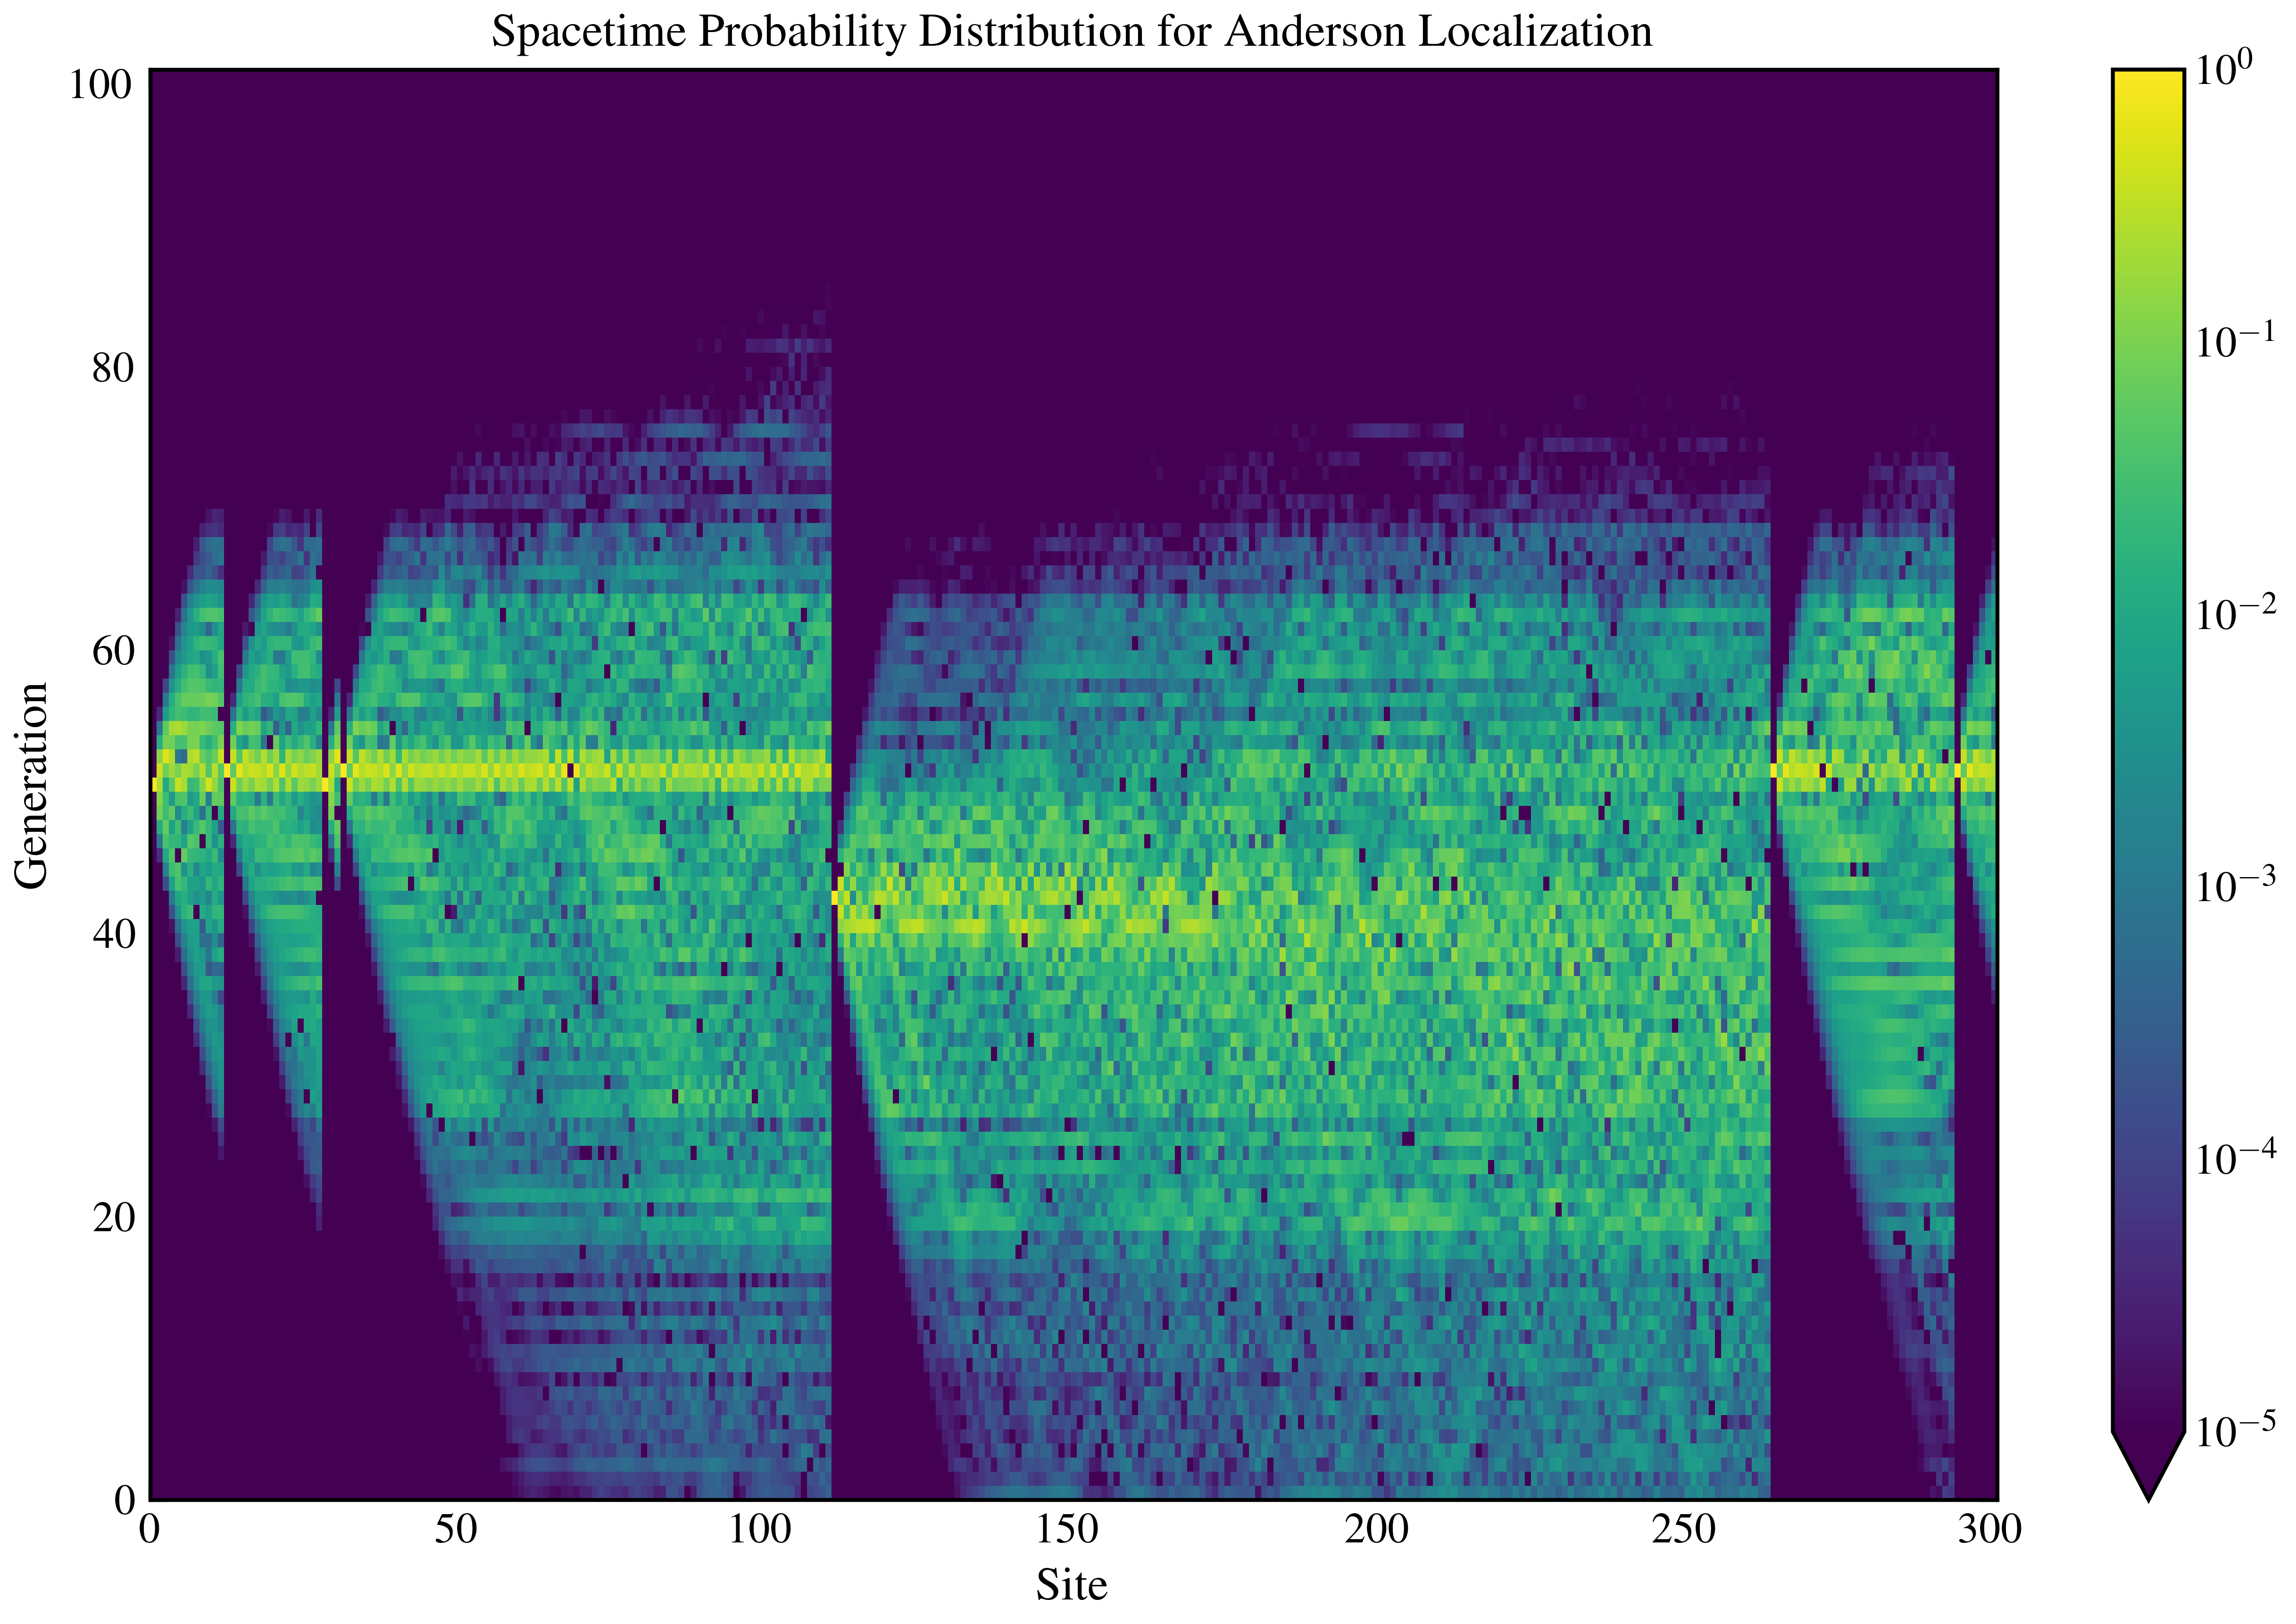

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
pc = ax.pcolormesh(
    np.where(prob <= 1e-10, 1e-10, prob).T,
    cmap="viridis",
    norm=colors.LogNorm(vmin=1e-5, vmax=1),
    shading="auto",
)
fig.colorbar(pc, ax=ax, extend="min")
ax.set_xlabel("Site")
ax.set_ylabel("Generation")
ax.set_title("Spacetime Probability Distribution for Anderson Localization")
plt.tight_layout()
plt.savefig("AC-LogScale.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()
# savefig()

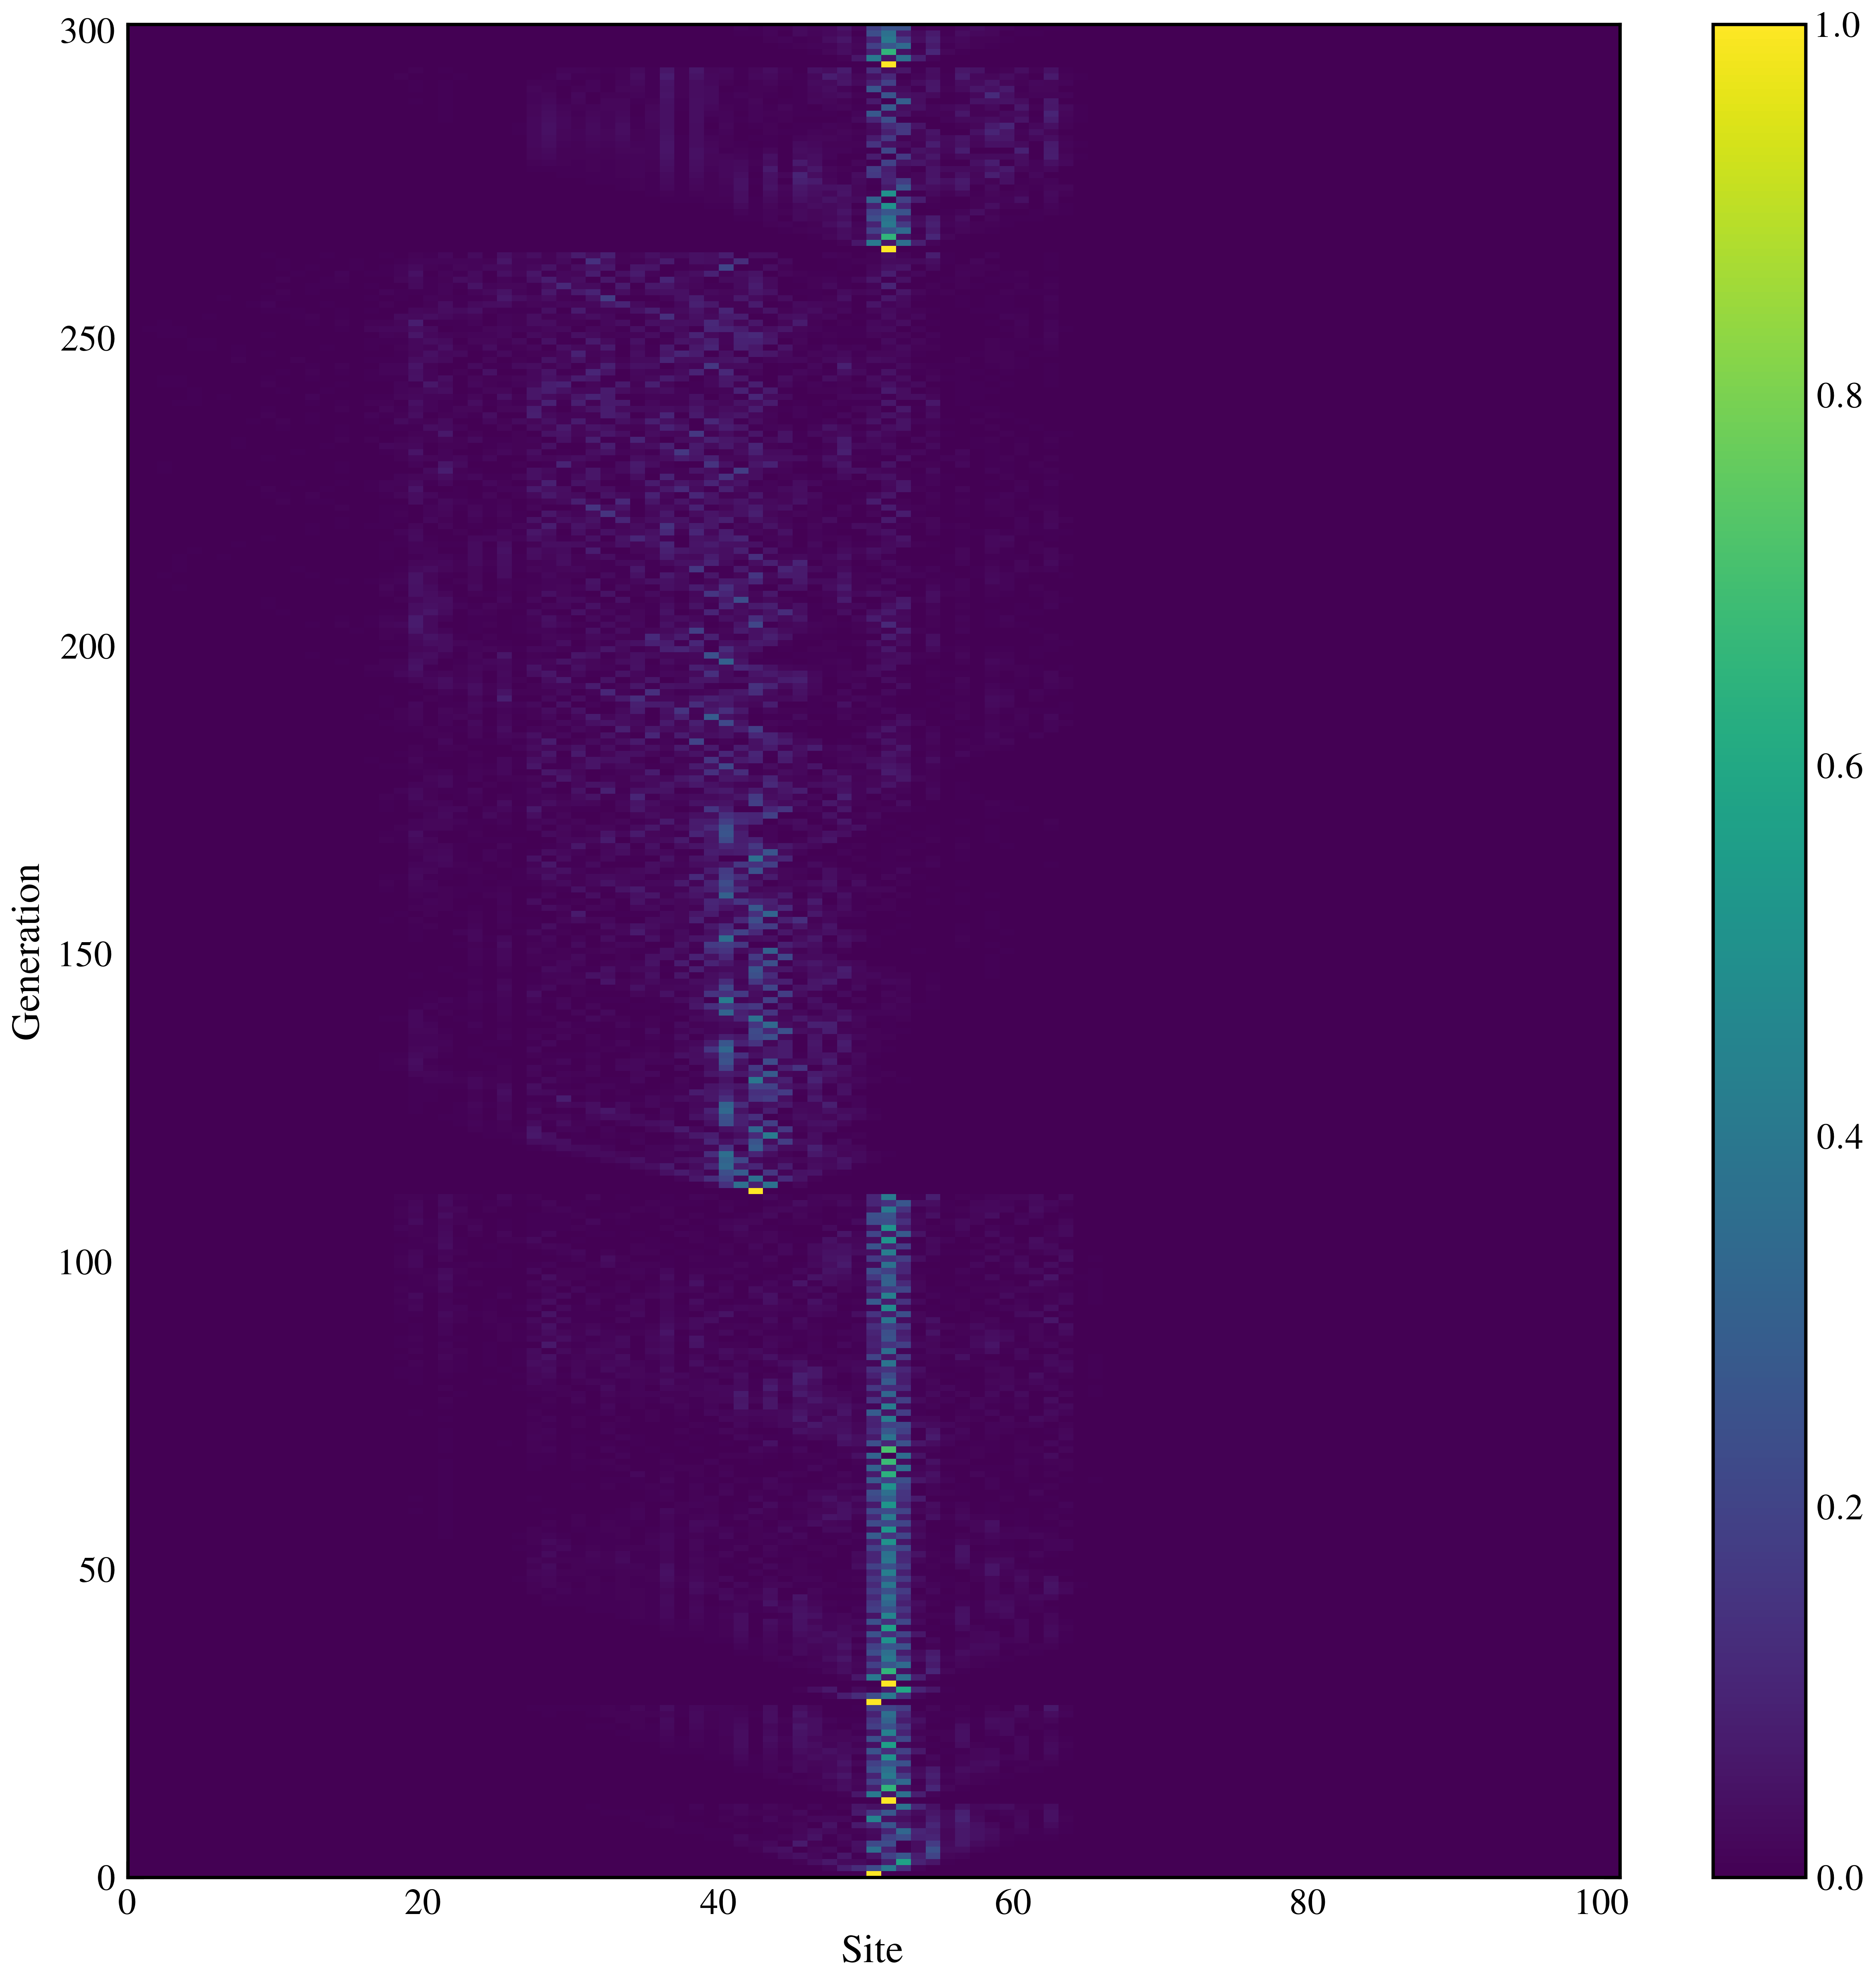

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
pc = ax.pcolormesh(prob, cmap="viridis", shading="auto")
fig.colorbar(pc, ax=ax)
ax.set_xlabel("Site")
ax.set_ylabel("Generation")
plt.savefig("AC-Normal.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

<Axes: >

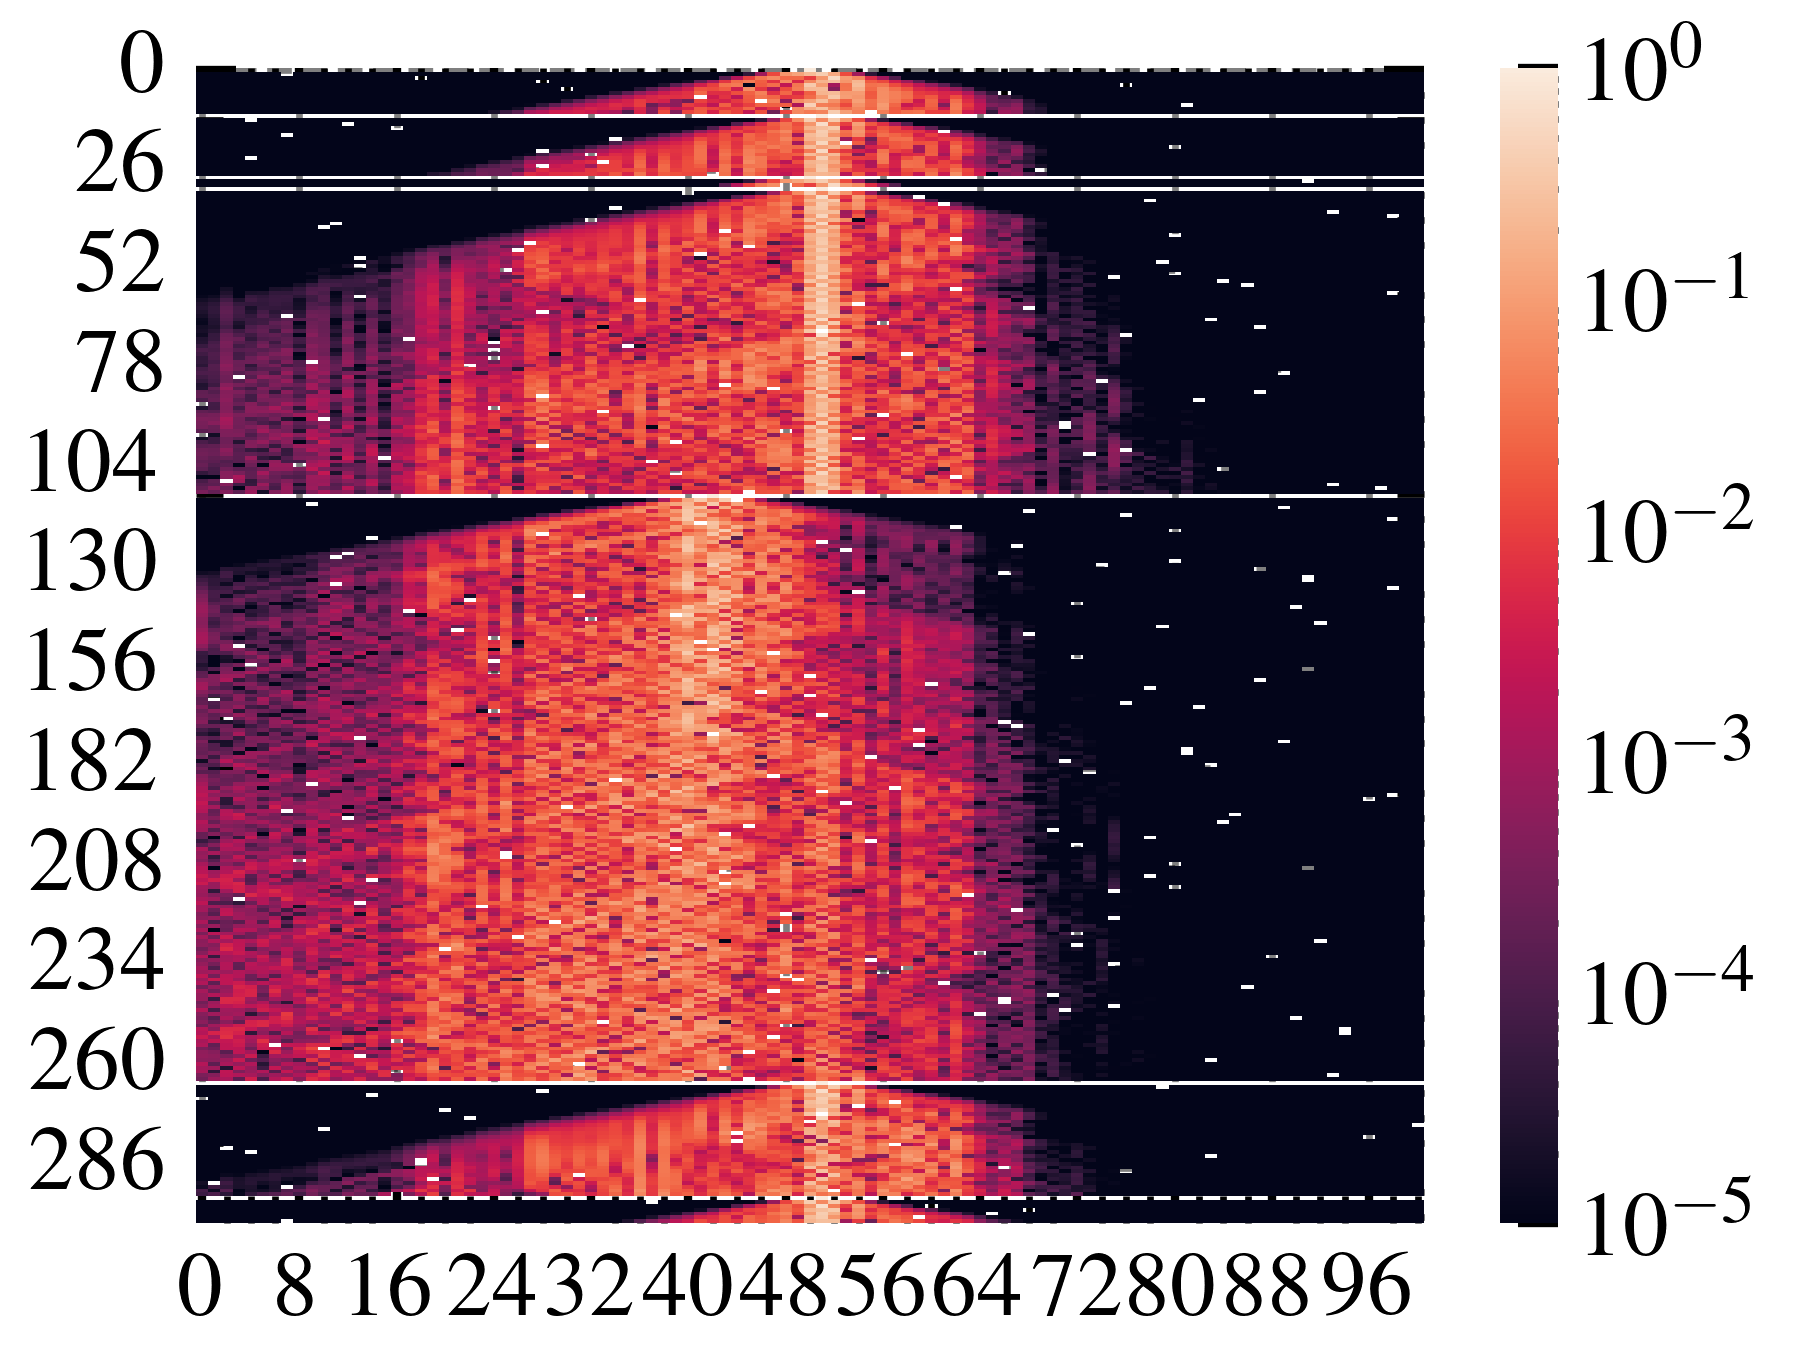

In [21]:
sns.set_context("paper", font_scale=1.25)
sns.heatmap(prob, norm=colors.LogNorm(vmin=1e-5, vmax=1), robust=True)